Higher School of Economics

National Research University

Master of Data Science Online Programme

Course: Research Seminar "Data Scraping"

Final Project: Parts 2 and 3

Student: Andrei Batyrov (Fall2022)

Date: 29-Jul-2023

##### Table of Contents

1. [Calculate movie distances](#calc)

2. [Distance report](#dist)

3. [Visualizing data](#plot)

    3.1. [Movie distances: all](#plot-all)

    3.2. [Movie distances: 1](#plot-1)
    
    3.3. [Movie distances: 2](#plot-2)

    3.4. [Movie distances: 3 or more](#plot-3)

4. [Word cloud](#cloud)

In [1]:
import time

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm
import networkx as nx
from wordcloud import WordCloud, STOPWORDS as default_stopwords

from imdb_code import (
                        get_movie_distance,
                        get_movie_descriptions_by_actor_soup
                        )
from imdb_helper_functions import (
                                    get_plot_attrs,
                                    plot_graph,
                                    format_str,
                                    get_soup_from_url,
                                    save_actor_descriptions_to_file,
                                    read_actor_descriptions_from_file,
                                    actor_name_to_filename,
                                    get_text_from_actor_descriptions
                                    )

In [2]:
# !pip install -r requirements.txt

---
##### <a id="calc"></a>1. Calculate movie distances

In [3]:
actors_2019 = {
                'Dwayne Johnson': 'https://www.imdb.com/name/nm0425005/fullcredits/', # with www
                'Chris Hemsworth': 'https://imdb.com/name/nm1165110/fullcredits', # w/o www
                'Robert Downey Jr.': 'https://www.imdb.com/name/nm0000375/fullcredits', # with www
                'Akshay Kumar': 'https://imdb.com/name/nm0474774/fullcredits', # w/o www
                'Jackie Chan': 'https://www.imdb.com/name/nm0000329/fullcredits', # with www
                'Bradley Cooper': 'https://imdb.com/name/nm0177896/fullcredits', # w/o www
                'Adam Sandler': 'https://www.imdb.com/name/nm0001191/fullcredits', # with www
                'Scarlett Johansson': 'https://imdb.com/name/nm0424060/fullcredits/', # w/o www
                'Sofía Vergara': 'https://www.imdb.com/name/nm0005527/fullcredits', # with www
                'Chris Evans': 'https://imdb.com/name/nm0262635/fullcredits' # w/o www
            }

In [4]:
# Calculate all distances, save them to file, and construct distance graph
G = nx.DiGraph()
G.name='Distance graph'
try:
    with open('distances.csv', 'w') as f:
        f.write("first actor's name,link to first actor's page,second actor's name,link to second actor's page,distance\n")
        start_time = time.time()
        i = 0
        for actor_start in tqdm(actors_2019, desc='Pair : Actor_start -> Actor_end : Distance'):
            j = 1
            for actor_end in actors_2019:
                if actor_start == actor_end:
                    continue
                # Calculate distance
                distance = get_movie_distance(actors_2019[actor_start], actors_2019[actor_end], num_of_actors_limit=34, num_of_movies_limit=None)
                if distance == 1:
                    color_code = '31' # red
                elif distance == 2:
                    color_code = '32' # green
                else:
                    color_code = '34' # blue
                print(f'{str(i * 9 + j):>2} : {actor_start:18} -> {actor_end:18} : \033[{color_code}m{distance:3}\033[0m')
                # Populate distance graph
                G.add_edge(format_str(actor_start, sep='\n'), format_str(actor_end, sep='\n'), distance=distance)
                # Populate distance file
                f.write(f'{actor_start},{actors_2019[actor_start]},{actor_end},{actors_2019[actor_end]},{distance}\n')
                j += 1
            i += 1
    end_time = time.time()
    print(f'\nSuccessfully constructed distance graph: {G}')
    print(f'Time taken: {round((end_time - start_time) / 60)} mins')
except Exception as e:
    print(f'Cannot continue: {repr(e)}')

Pair : Actor_start -> Actor_end : Distance:   0%|          | 0/10 [00:00<?, ?it/s]

 1 : Dwayne Johnson     -> Chris Hemsworth    :   2
 2 : Dwayne Johnson     -> Robert Downey Jr.  :   2
 3 : Dwayne Johnson     -> Akshay Kumar       :   2
 4 : Dwayne Johnson     -> Jackie Chan        :   2
 5 : Dwayne Johnson     -> Bradley Cooper     :   2
 6 : Dwayne Johnson     -> Adam Sandler       :   2
 7 : Dwayne Johnson     -> Scarlett Johansson :   2
 8 : Dwayne Johnson     -> Sofía Vergara      :   2
 9 : Dwayne Johnson     -> Chris Evans        :   1
10 : Chris Hemsworth    -> Dwayne Johnson     :   2
11 : Chris Hemsworth    -> Robert Downey Jr.  :   1
12 : Chris Hemsworth    -> Akshay Kumar       :   2
13 : Chris Hemsworth    -> Jackie Chan        :   2
14 : Chris Hemsworth    -> Bradley Cooper     :   1
15 : Chris Hemsworth    -> Adam Sandler       :   2
16 : Chris Hemsworth    -> Scarlett Johansson :   1
17 : Chris Hemsworth    -> Sofía Vergara      :   2
18 : Chris Hemsworth    -> Chris Evans        :   1
19 : Robert Downey Jr.  -> Dwayne Johnson     :   2
20 : Robert 

---
##### <a id="dist"></a>2. Distance report

In [5]:
# Show randomly chosen ten actor pairs
distances_df = pd.read_csv('distances.csv')
(distances_df
.iloc[sorted(np.random.choice(range(distances_df.shape[0]), 10))]
.style
    .set_caption('<h4>Ten randomly chosen actor pairs</h4>')
    .format({
                "link to first actor's page": lambda x: f'<a href="{x}">{x}</a>',
                "link to second actor's page": lambda x: f'<a href="{x}">{x}</a>'
                })
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left')]},
                        {'selector': 'tr', 'props': [('text-align', 'left')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}
                        ])
)

,first actor's name,link to first actor's page,second actor's name,link to second actor's page,distance
7,Dwayne Johnson,https://www.imdb.com/name/nm0425005/fullcredits/,Sofía Vergara,https://www.imdb.com/name/nm0005527/fullcredits,2
11,Chris Hemsworth,https://imdb.com/name/nm1165110/fullcredits,Akshay Kumar,https://imdb.com/name/nm0474774/fullcredits,2
18,Robert Downey Jr.,https://www.imdb.com/name/nm0000375/fullcredits,Dwayne Johnson,https://www.imdb.com/name/nm0425005/fullcredits/,2
24,Robert Downey Jr.,https://www.imdb.com/name/nm0000375/fullcredits,Scarlett Johansson,https://imdb.com/name/nm0424060/fullcredits/,1
34,Akshay Kumar,https://imdb.com/name/nm0474774/fullcredits,Sofía Vergara,https://www.imdb.com/name/nm0005527/fullcredits,2
35,Akshay Kumar,https://imdb.com/name/nm0474774/fullcredits,Chris Evans,https://imdb.com/name/nm0262635/fullcredits,2
43,Jackie Chan,https://www.imdb.com/name/nm0000329/fullcredits,Sofía Vergara,https://www.imdb.com/name/nm0005527/fullcredits,2
53,Bradley Cooper,https://imdb.com/name/nm0177896/fullcredits,Chris Evans,https://imdb.com/name/nm0262635/fullcredits,1
67,Scarlett Johansson,https://imdb.com/name/nm0424060/fullcredits/,Jackie Chan,https://www.imdb.com/name/nm0000329/fullcredits,2
87,Chris Evans,https://imdb.com/name/nm0262635/fullcredits,Adam Sandler,https://www.imdb.com/name/nm0001191/fullcredits,2


In [6]:
# Prepare a pivot table for all pairs of actors
distance_pivot = pd.pivot_table(
                data=distances_df, 
                values='distance',  
                index="first actor's name", 
                columns="second actor's name", 
                aggfunc='sum', 
                margins=True, 
                margins_name='Total')

# Sort distances to show possible clusters
distance_pivot = distance_pivot.sort_values(by='Total', axis=0).sort_values(by='Total', axis=1)

# Apply style
(distance_pivot
.style
    .set_caption('<h4>Pairwise distances between actors</h4>')
    .format(precision=0, na_rep='-')
    .highlight_between(
        left=1,
        right=1,
        props='background-color:rgb(255, 0, 0, 0.1);') # red
    .highlight_between(
        left=2,
        right=2,
        props='background-color:rgb(144, 238, 144, 0.2);') # green
    .set_table_styles([
                        {'selector': 'th', 'props': [('text-align', 'left'), ('font-weight', 'normal')]},
                        {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}, # yellow
                        {'selector': 'td:hover', 'props': [('font-weight', 'bold')]}
                        ])
)

second actor's name,Chris Evans,Robert Downey Jr.,Scarlett Johansson,Bradley Cooper,Chris Hemsworth,Sofía Vergara,Dwayne Johnson,Adam Sandler,Akshay Kumar,Jackie Chan,Total
first actor's name,,,,,,,,,,,
Chris Evans,-,1,1,1,1,2,1,2,2,2,13
Robert Downey Jr.,1,-,1,1,1,1,2,2,2,2,13
Scarlett Johansson,1,1,-,1,1,1,2,2,2,2,13
Bradley Cooper,1,1,1,-,1,2,2,2,2,2,14
Chris Hemsworth,1,1,1,1,-,2,2,2,2,2,14
Sofía Vergara,2,1,1,2,2,-,2,2,2,2,16
Dwayne Johnson,1,2,2,2,2,2,-,2,2,2,17
Adam Sandler,2,2,2,2,2,2,2,-,2,2,18
Akshay Kumar,2,2,2,2,2,2,2,2,-,2,18


---
##### <a id="plot"></a>3. Visualizing data

In [7]:
# Get sorted list of nodes by quasi-degree: sum of distances for each node
nlist = [format_str(actor_name, sep='\n') for actor_name in distances_df.groupby("first actor's name")['distance'].sum().sort_values(ascending=True).index.to_list()]

##### <a id="plot-all"></a>3.1. Movie distances: all

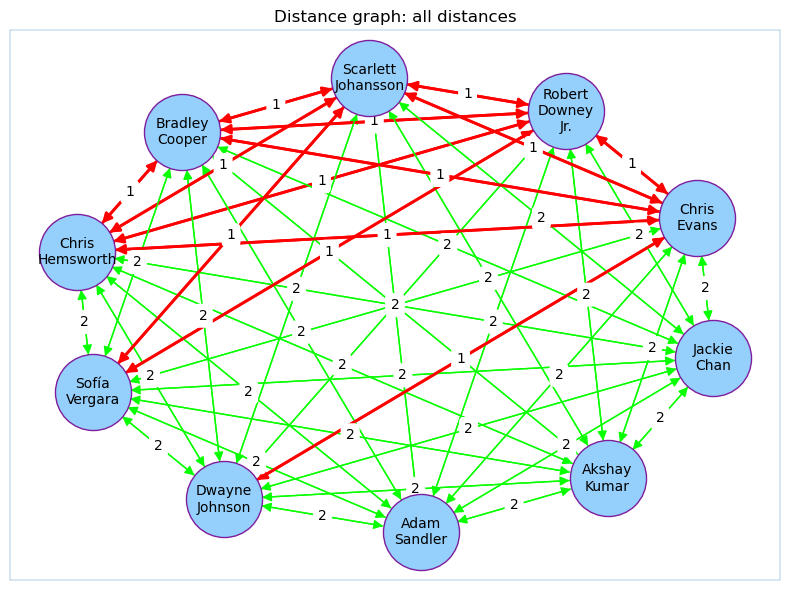

In [8]:
distance = None
plot_attrs = get_plot_attrs(G, distance)
plot_graph(G, 'all distances', *plot_attrs, nlist=[nlist], rad=0.3927, save_to_file=True)

##### <a id="plot-1"></a>3.2. Movie distances: 1

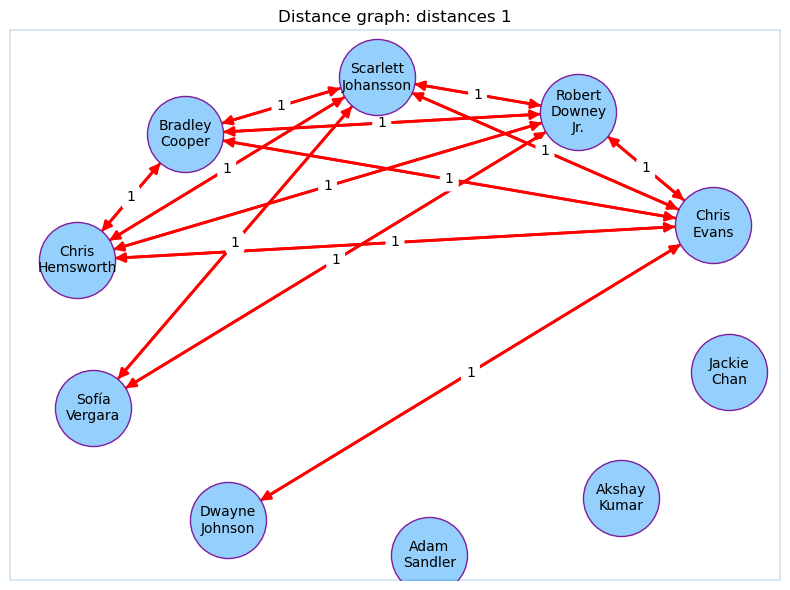

In [9]:
distance = 1
plot_attrs = get_plot_attrs(G, distance)
plot_graph(G, 'distances 1', *plot_attrs, nlist=[nlist], rad=0.3927, save_to_file=True)

##### <a id="plot-2"></a>3.3. Movie distances: 2

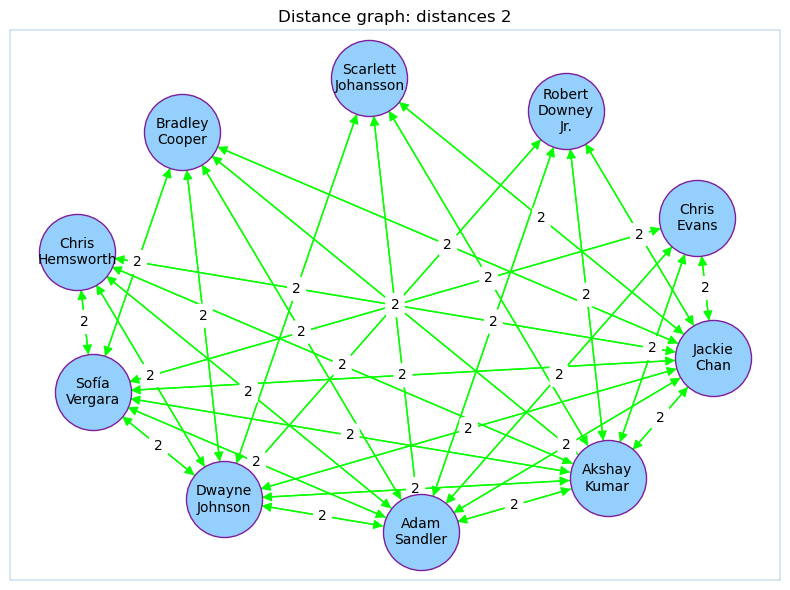

In [10]:
distance = 2
plot_attrs = get_plot_attrs(G, distance)
plot_graph(G, 'distances 2', *plot_attrs, nlist=[nlist], rad=0.3927, save_to_file=True)

##### <a id="plot-3"></a>3.4. Movie distances: 3 or more

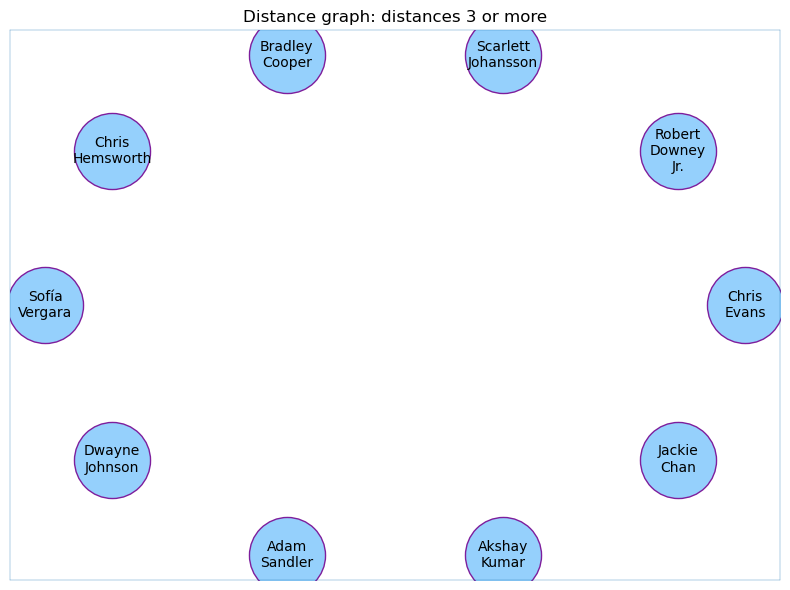

In [11]:
distance = 3
plot_attrs = get_plot_attrs(G, distance)
plot_graph(G, 'distances 3 or more', *plot_attrs, nlist=[nlist], rad=0, save_to_file=True)

---
##### <a id="cloud"></a>4. Word cloud

In [12]:
# Collect all movies descriptions for all actors and save them to individual files
try:
    start_time = time.time()
    for i, actor in enumerate(tqdm(actors_2019, desc='Actor'), start=1):
        print(f'{str(i):>2}. {actor}')
        actor_soup = get_soup_from_url(actors_2019[actor])
        actor_descriptions = get_movie_descriptions_by_actor_soup(actor_soup)
        #print(actor_descriptions)
        save_actor_descriptions_to_file(actor, actor_descriptions)
    end_time = time.time()
    print('Successfully collected and saved all movie descriptions for all actors')
    print(f'Time taken: {round((end_time - start_time) / 60)} mins')
except Exception as e:
    print(f'Cannot continue: {repr(e)}')

Actor:   0%|          | 0/10 [00:00<?, ?it/s]

 1. Dwayne Johnson


  0%|          | 0/46 [00:00<?, ?it/s]

 2. Chris Hemsworth


  0%|          | 0/29 [00:00<?, ?it/s]

 3. Robert Downey Jr.


  0%|          | 0/73 [00:00<?, ?it/s]

 4. Akshay Kumar


  0%|          | 0/144 [00:00<?, ?it/s]

 5. Jackie Chan


  0%|          | 0/131 [00:00<?, ?it/s]

 6. Bradley Cooper


  0%|          | 0/45 [00:00<?, ?it/s]

 7. Adam Sandler


  0%|          | 0/54 [00:00<?, ?it/s]

 8. Scarlett Johansson


  0%|          | 0/55 [00:00<?, ?it/s]

 9. Sofía Vergara


  0%|          | 0/28 [00:00<?, ?it/s]

10. Chris Evans


  0%|          | 0/42 [00:00<?, ?it/s]

Successfully collected and saved all movie descriptions for all actors
Time taken: 17 mins


In [13]:
# Show randomly chosen five movie descriptions for randomly chosen actor
actor_random = np.random.choice(list(actors_2019.keys()))
actor_random_descriptions = pd.DataFrame(read_actor_descriptions_from_file(actor_random))
(actor_random_descriptions
.iloc[sorted(np.random.choice(range(actor_random_descriptions.shape[0]), 5))]
.style
    .set_caption(f'<h4>Five randomly chosen movie descriptions for <a href="{actor_name_to_filename(actor_random)}" title="{actor_name_to_filename(actor_random)}">{actor_random}</a></h4>')
    .hide(axis=1)
    .set_table_styles([
                    {'selector': 'th', 'props': [('text-align', 'center')]},
                    {'selector': 'td', 'props': [('width', '700px')]},
                    {'selector': 'tr', 'props': [('text-align', 'left')]},
                    {'selector': 'tbody>tr:hover', 'props': [('background-color', 'lightyellow')]}
                    ])
)

0,"After barely surviving his grievous wounds from his mission in Dhaka, Bangladesh, Tyler Rake is back, and his team is ready to take on their next mission."
9,The Avengers and their allies must be willing to sacrifice all in an attempt to defeat the powerful Thanos before his blitz of devastation and ruin puts an end to the universe.
19,"When the Dark Elves attempt to plunge the universe into darkness, Thor must embark on a perilous and personal journey that will reunite him with doctor Jane Foster."
20,The merciless 1970s rivalry between Formula One rivals James Hunt and Niki Lauda.
20,The merciless 1970s rivalry between Formula One rivals James Hunt and Niki Lauda.


In [14]:
# Check WordCloud's default stopwords -- looks good, let's use this set
default_stopwords_list = sorted(list(default_stopwords))
default_stopwords_2d = []
# 192 = 16 * 12 number of default stopwords
for i in range(16):
    row = []
    for j in range(12):
        row.append(default_stopwords_list[i * 12 + j])
    default_stopwords_2d.append(row)
(pd.DataFrame(default_stopwords_2d)
.style
    .set_caption('<h4>WordCloud default stopwords</h4>')
    .hide(axis='index')
    .hide(axis=1)
    .set_table_styles([
                        {'selector': 'tr', 'props': [('text-align', 'left')]},
                        {'selector': 'td:hover', 'props': [('background-color', 'lightyellow')]}
                        ])
)

a,about,above,after,again,against,all,also,am,an,and,any
are,aren't,as,at,be,because,been,before,being,below,between,both
but,by,can,can't,cannot,com,could,couldn't,did,didn't,do,does
doesn't,doing,don't,down,during,each,else,ever,few,for,from,further
get,had,hadn't,has,hasn't,have,haven't,having,he,he'd,he'll,he's
hence,her,here,here's,hers,herself,him,himself,his,how,how's,however
http,i,i'd,i'll,i'm,i've,if,in,into,is,isn't,it
it's,its,itself,just,k,let's,like,me,more,most,mustn't,my
myself,no,nor,not,of,off,on,once,only,or,other,otherwise
ought,our,ours,ourselves,out,over,own,r,same,shall,shan't,she
she'd,she'll,she's,should,shouldn't,since,so,some,such,than,that,that's


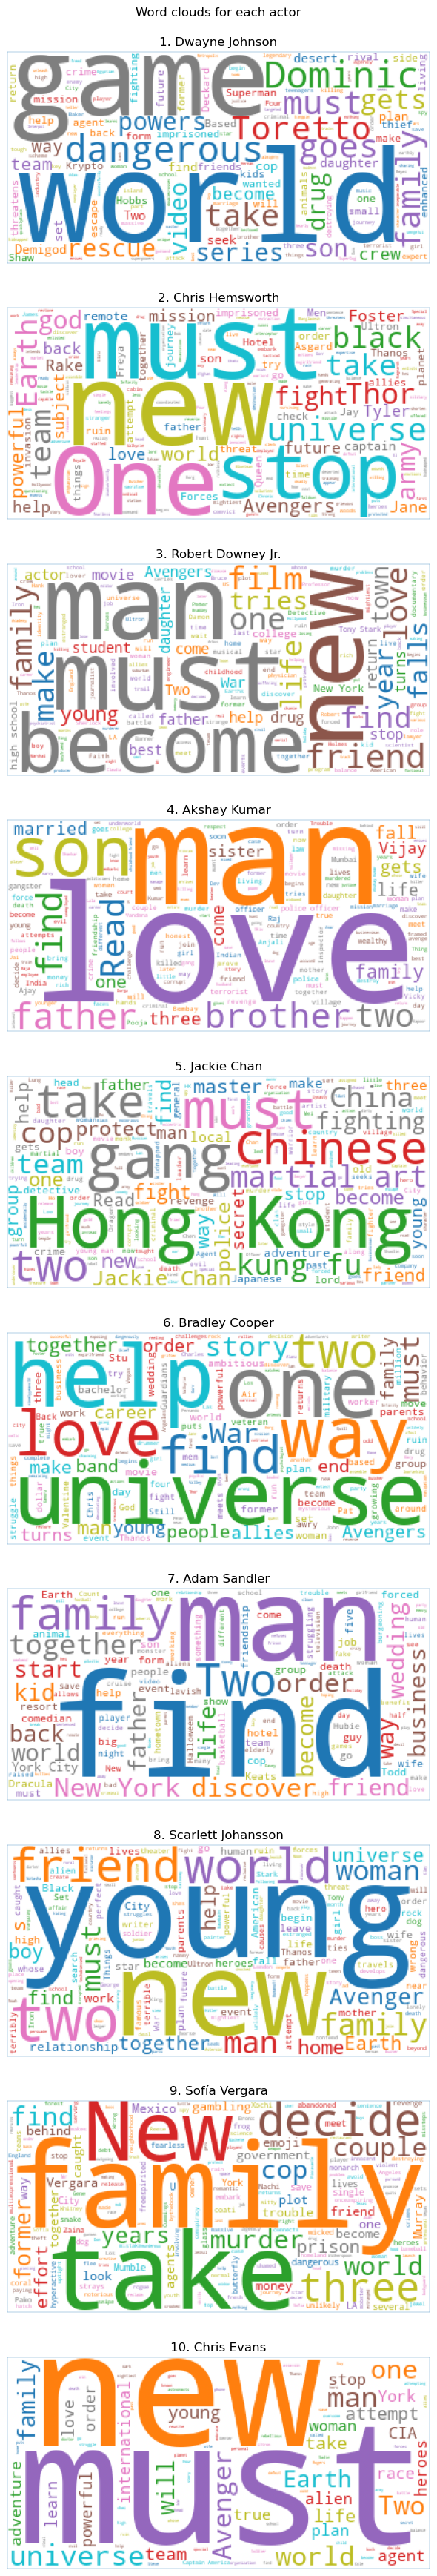

In [15]:
# Finally show word clouds for each actor
colormap = matplotlib.cm.get_cmap('tab10')
plt.figure(figsize=(6, 35))
plt.suptitle("Word clouds for each actor", y=0.995)
for i, actor in enumerate(actors_2019, start=1):
    actor_descriptions = read_actor_descriptions_from_file(actor)
    actor_text = get_text_from_actor_descriptions(actor_descriptions)
    wordcloud = WordCloud(background_color='white', colormap=colormap, collocations=True, stopwords=default_stopwords).generate(actor_text)
    plt.subplot(10, 1, i)
    plt.imshow(wordcloud)
    plt.title(f'{i}. {actor}')
    # Blue box around plot
    spines = plt.gca().spines
    for axis in ['top', 'bottom', 'left', 'right']:
        spines[axis].set_linewidth(0.25)
        spines[axis].set_color('C0')
    # Turn off axes ticks
    plt.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
plt.tight_layout();